###  The code in this notebook can be used to replicate:
    1. Figure 4
    2. Extended Data Figures 6 - 9

######  Panels 4c, 4d, 4e and Extended Data Figures 7, 8, 9b-d  are generated in https://github.com/SlavovLab/decode/tree/main/decode_analysis code
###### Generating panel 4f and Extended Data Figure 9e,f  is described in the methods

#### Decode pipeline output files (provided in https://drive.google.com/drive/folders/15YoTBTZh4MdtAqHbibkYieEqyLyFi5hb?usp=sharing or generated by rerunning pipeline https://github.com/SlavovLab/decode/tree/main/decode_pipeline) required: 

    1. "Supplemental_Data_2.SAAP_proteins.xlsx"
    2. "Supplemental_Data_3.SAAP_precursor_quant.xlsx"
    3. "Supplemental_Data_4.SAAP_reporter_quant.xlsx"  
    4. "S044_CPTAC_CCRCC_Discovery_Cohort_Clinical_Data_r2_Jan2019.xlsx" (CCRCC clinical data in pipeline_output/CCRCC/Publication/CPTAC_ccRCC_metadata)
    5. "S063_S058_CPTAC_LSCC_Discovery_Cohort_Clinical_Data_r2_July2021.xlsx" (LSCC clinical data in pipeline_output/LSCC/Publication)
    6. "S061_CPTAC_PDA_Discovery_Cohort_Clinical_Data_r1_Feb2021.xlsx" (PDAC clinical data in pipeline_output/PDAC/Publication)
    7. "S053_S043_CPTAC_UCEC_Discovery_Cohort_Clinical_Data_r2_Feb2020.xlsx" (UCEC clinical data in pipeline_output/UCEC/Publication)
    8. "mmc1_metadata.xlsx" (LUAD clinical data in pipeline_output/LUAD/Publication)
    9. "Krug_metaData.xlsx" (BRCA clinical data in pipeline_output/BRCA/Publication)
    10. "All_DS_Pfam_dom_dict.p" (in pipeline_output/analysis_dependencies)
    11. "Pfam_Domains_RAAS_SigIn4.xlsx" (in pipeline_output/analysis_dependencies; also generated here, but manually combined related domains with same RAAS)
    12. "Pfam_Domains_Npeps_SigIn4.xlsx" (in pipeline_output/analysis_dependencies; also generated here, but manually combined related domains with same RAAS)
    


*** It is highly recommended to maintain the same directory structure as in the Google Drive ***


The code in this notebook is organized and labeled by references to figures in the manuscript. It is recommended to find and run the analyses of interest, rather than running the entire script at once. E.g. search page for "Figure 4a" to find code to replicate that data.

In [49]:
# read in packages needed

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from collections import Counter
import scipy as sp
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import os
import ast
from scipy.odr import Model, RealData, ODR
from scipy.stats import gaussian_kde
from matplotlib import gridspec
import milkviz as mv
from matplotlib_venn import venn3
import zipfile
from glob import glob
import gzip
import tarfile
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.collections import PatchCollection

#### Setting directories and reading in data.

All of these directories should be updated by the user to reflect where their output data from the decode pipeline st stored.


In [5]:
proj_dir = '/Users/shiri/Library/CloudStorage/GoogleDrive-tsour.s@husky.neu.edu/My Drive/MS/SuppData/2024_Tsour/'

ccrcc_proj_dir = proj_dir+'pipeline_output/CCRCC/'
ccrcc_aa_subs_dir = ccrcc_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
ccrcc_sample_map = pd.read_excel(ccrcc_aa_subs_dir+'sample_map.xlsx')
ccrcc_samples = ['S'+str(i) for i in list(set(ccrcc_sample_map['TMT plex']))]

ucec_proj_dir = proj_dir+'pipeline_output/UCEC/'
ucec_aa_subs_dir = ucec_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
ucec_sample_map = pd.read_excel(ucec_aa_subs_dir+'sample_map.xlsx')
ucec_samples = ['S'+str(i) for i in list(set(ucec_sample_map['TMT plex']))]

brca_proj_dir = proj_dir+'pipeline_output/BRCA/'
brca_aa_subs_dir = brca_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
brca_sample_map = pd.read_excel(brca_aa_subs_dir+'sample_map.xlsx')
brca_samples = ['S'+str(i) for i in list(set(brca_sample_map['TMT plex']))]

luad_proj_dir = proj_dir+'pipeline_output/LUAD/'
luad_aa_subs_dir = luad_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
luad_sample_map = pd.read_excel(luad_aa_subs_dir+'sample_map.xlsx')
luad_samples = ['S'+str(i) for i in list(set(luad_sample_map['TMT plex']))]

pdac_proj_dir = proj_dir+'pipeline_output/PDAC/'
pdac_aa_subs_dir = pdac_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
pdac_sample_map = pd.read_excel(pdac_aa_subs_dir+'sample_map.xlsx')
pdac_samples = ['S'+str(i) for i in list(set(pdac_sample_map['TMT plex']))]

lscc_proj_dir = proj_dir+'pipeline_output/LSCC/'
lscc_aa_subs_dir = lscc_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
lscc_sample_map = pd.read_excel(lscc_aa_subs_dir+'sample_map.xlsx')
lscc_samples = ['S'+str(i) for i in list(set(lscc_sample_map['TMT plex']))]

wang_proj_dir = proj_dir+'pipeline_output/HealthyTissues/'
wang_data_dir = wang_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
wang_samples = open(wang_data_dir+'proteomic_tissue_list.txt', 'r').read().split('\n')
wang_samples = [x for x in wang_samples if x!='rectum']

# lists used to quickly index dataset-specific sample maps (e.g.) from just the dataset name
datasets = ['CCRCC', 'UCEC', 'BRCA', 'LUAD', 'PDAC', 'LSCC', 'Healthy']
data_dir_list = [ccrcc_aa_subs_dir, ucec_aa_subs_dir, brca_aa_subs_dir, luad_aa_subs_dir, pdac_aa_subs_dir, lscc_aa_subs_dir, wang_data_dir]
samples_list = [ccrcc_samples, ucec_samples, brca_samples, luad_samples, pdac_samples, lscc_samples, wang_samples]
sample_map_list = [ccrcc_sample_map, ucec_sample_map, brca_sample_map, luad_sample_map, pdac_sample_map, lscc_sample_map]
proj_dir_list = [ccrcc_proj_dir, ucec_proj_dir, brca_proj_dir, luad_proj_dir, pdac_proj_dir, lscc_proj_dir, wang_proj_dir]

dependencies_dir = proj_dir+'pipeline_output/analysis_dependencies/'
outdir = 'figures_testing/' # output directory where to save figures

In [6]:
class GridShader():
    """
    function used to create alternating vertical gray and white background in plots
    """
    def __init__(self, ax, first=True, **kwargs):
        self.spans = []
        self.sf = first
        self.ax = ax
        self.kw = kwargs
        self.ax.autoscale(False, axis="x")
        self.cid = self.ax.callbacks.connect('xlim_changed', self.shade)
        self.shade()
    def clear(self):
        for span in self.spans:
            try:
                span.remove()
            except:
                pass
    def shade(self, evt=None):
        self.clear()
        xticks = self.ax.get_xticks()
        xlim = self.ax.get_xlim()
        xticks = xticks[(xticks > xlim[0]) & (xticks < xlim[-1])]
        locs = np.concatenate(([[xlim[0]], xticks, [xlim[-1]]]))

        start = [x-0.5 for x in locs[1-int(self.sf)::2]]
        end = [x-0.5 for x in locs[2-int(self.sf)::2]]

        for s, e in zip(start, end):
            self.spans.append(self.ax.axvspan(s, e, zorder=0, **self.kw))


def bihist(y1, y2, nbins=10, h=None):
    '''
    Function used to create violin plots as bihistograms with no smoothing.
    h is an axis handle. If not present, a new figure is created.
    '''
    if h is None: h = plt.figure().add_subplot(111)
    ymin = np.floor(np.minimum(min(y1), min(y2)))
    ymax = np.ceil(np.maximum(max(y1), max(y2)))
    bins = np.linspace(ymin, ymax, nbins)
    n1, bins1, patch1 = h.hist(y1, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    n2, bins2, patch2 = h.hist(y2, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    # set xmax:
    xmax = 0
    for i in patch1:
        i.set_edgecolor(None)
        width = i.get_width()
        if width > xmax: xmax = width
    # invert second histogram and set xmin:
    xmin = 0
    for i in patch2:
        i.set_edgecolor(None)
        width = i.get_width()
        width = -width
        i.set_width(width)
        if width < xmin: xmin = width
    h.set_xlim(xmin*1.1, xmax*1.1)          
    h.figure.canvas.draw()

# Figure 4. Tumor vs. Normal analysis

#### Incl. Extended Data Figure 6, 9

Run next cell for all analyses

In [52]:
filt_saap_df = pd.read_excel(proj_dir+'Supplemental_Data_2.SAAP_proteins.xlsx', index_col=0)
filt_prec_quant_df = pd.read_excel(proj_dir+'Supplemental_Data_3.SAAP_precursor_quant.xlsx', index_col=0)
filt_reporter_quant_df = pd.read_excel(proj_dir+'Supplemental_Data_4.SAAP_reporter_quant.xlsx', index_col=0)

# custom colormap
# this colormap is used for all RAAS dotplots 

import matplotlib
from matplotlib.cm import get_cmap
inferno_cmap = get_cmap('inferno')
viridis_cmap = get_cmap('viridis')

inferno_colors = inferno_cmap.colors
viridis_colors = viridis_cmap.colors

inferno_colors[-1] = viridis_colors[-1]
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", inferno_colors)

### Extended Data Figure 6a: Distribution of RAAS fold changes between tumor and normal samples 

In [8]:
# create dictionary with fold changes for each SAAP's RAAS computed between normal and tumor samples from same patient
# uses saap_protein_df, i.e. Supplemental_Data_2.SAAP_proteins.xlsx (read in earlier in script)
# uses reporter_quant_df, i.e. Supplemental_Data_4.SAAP_reporter_quant.xlsx (read in earlier in script)

tvn_datasets = [x for x in datasets if x!='BRCA' and x!='Healthy'] # BRCA not included because only tumor data
filt_reporter_quant_df['Patient ID'] = [x.split('_')[0] for x in filt_reporter_quant_df['Sample name'].values]


patient_level_tvn_dict = {ds:{} for ds in tvn_datasets}
for ds in tvn_datasets: 
    print(ds)
    ds_saap_df = filt_saap_df.loc[filt_saap_df['Dataset']==ds]
    ds_quant_df = filt_reporter_quant_df.loc[filt_reporter_quant_df['Dataset']==ds]
    set_patients = list(set(filt_reporter_quant_df['Patient ID'].values))
    patient_level_tvn_rows = []
    patient_level_tvn_cols = ['Dataset', 'SAAP', 'BP','Patient ID', 'Tumor TMT set', 'Normal TMT set', 'Tumor SAAP', 'Normal SAAP','Log$_2$Tumor/Normal SAAP', 'Tumor BP', 'Normal BP','Log$_2$Tumor/Normal BP', 'Tumor RAAS', 'Normal RAAS', 'Log$_2$Tumor/Normal RAAS']

    for i,row in ds_saap_df.iterrows():
        saap = row['SAAP']
        bp = row['BP']
        saap_df = ds_quant_df.loc[(ds_quant_df['SAAP']==saap) & (ds_quant_df['BP']==bp)]
        for patient in set_patients:
            patient_df = saap_df.loc[saap_df['Patient ID']==patient]
            if 'Tumor' in patient_df['Sample type'].values and 'Normal' in patient_df['Sample type'].values:
                t_row = patient_df.loc[patient_df['Sample type']=='Tumor']
                n_row = patient_df.loc[patient_df['Sample type']=='Normal']

                t_saap = t_row['SAAP abundance'].values[0]
                t_bp = t_row['BP abundance'].values[0]
                t_raas = t_row['RAAS'].values[0]
                t_tmt = t_row['TMT set'].values[0]

                n_saap = n_row['SAAP abundance'].values[0]
                n_bp = n_row['BP abundance'].values[0]
                n_raas = n_row['RAAS'].values[0]
                n_tmt = n_row['TMT set'].values[0]    

                saap_fc = np.log2(t_saap/n_saap)
                bp_fc = np.log2(t_bp/n_bp)
                raas_fc = np.log2((10**t_raas)/(10**n_raas))

                patient_level_tvn_rows.append([ds, saap, bp, patient, t_tmt, n_tmt,
                                              t_saap, n_saap, saap_fc, t_bp, n_bp, bp_fc, t_raas, n_raas, raas_fc])
    patient_level_tvn_df = pd.DataFrame(patient_level_tvn_rows, columns=patient_level_tvn_cols)
    patient_level_tvn_dict[ds] = patient_level_tvn_df
pickle.dump(patient_level_tvn_dict, open(outdir+'Patient_level_Tumor_v_Normal_data.p','wb'))

CCRCC


/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log2
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log2
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipyke

UCEC
LUAD
PDAC
LSCC


CCRCC
UCEC
LUAD
PDAC
LSCC


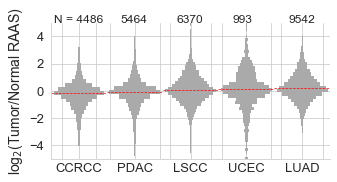

In [10]:
# plot overall distribution of tumor vs normal RAAS value for each SAAP. Computed with matched patient samples

tvn_dict = patient_level_tvn_dict

col2plot = 'Log$_2$Tumor/Normal RAAS'

sns.set_style('whitegrid')
fig,axes = plt.subplots(1,len(tvn_datasets),figsize=(5,2.5), sharey=True)

plt.subplots_adjust(wspace=0)
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params('x', bottom=False,labelbottom=False)
    if ax!=axes[0]:    
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)

# sort datasets in plot by median of distribution 
medians = []
for ds in tvn_datasets:
    ds_df = tvn_dict[ds]
    data = [x for x in ds_df[col2plot].values if ~np.isnan(x) and ~np.isinf(x)]
    medians.append(np.median(data))
med_sort_idx = list(np.argsort(medians))

for i,ds in enumerate(tvn_datasets):
    print(ds)
    ax_idx = med_sort_idx.index(i)
    axes[ax_idx].set_xlabel(ds, fontsize=13)
    ds_df = tvn_dict[ds]
    data = [x for x in ds_df[col2plot].values if ~np.isnan(x) and ~np.isinf(x)]
    bihist(data, data, nbins=70,h=axes[ax_idx])
    if ax_idx==0:
        axes[ax_idx].annotate('N = '+str(len(data)),(0.05,1), xycoords='axes fraction', fontsize=12)
    else:
        axes[ax_idx].annotate(str(len(data)), (0.25,1), xycoords='axes fraction', fontsize=12)
    axes[ax_idx].plot((axes[ax_idx].get_xlim()), (np.median(data), np.median(data)), '--r',linewidth=0.7)
axes[0].set_ylabel('log$_2$(Tumor/Normal RAAS)', fontsize=14)
axes[0].tick_params('both', labelsize=13)
plt.ylim([-5,5])
plt.savefig(outdir+'patient_level_Tv_RAAS_bihist.pdf', bbox_inches='tight')

### Figure 4a: Tumor vs Normal RAAS in patients for LaminA SAAP 

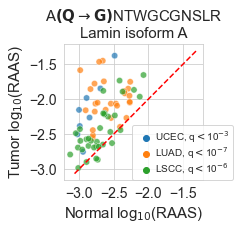

In [14]:
saap = 'AGNTWGCGNSLR'

# get data for plot from tvn_dict
saap_df_list = []
for ds in tvn_datasets:
    ds_df = tvn_dict[ds]
    saap_df = ds_df.loc[ds_df['SAAP']==saap]
    saap_df_list.append(saap_df)
all_ds_saap_df = pd.concat(saap_df_list)
all_ds_saap_df = all_ds_saap_df.loc[:,['Dataset','Patient ID','Tumor RAAS','Normal RAAS']]
all_ds_saap_df.replace(np.inf, np.nan, inplace=True)
all_ds_saap_df.replace(-np.inf, np.nan, inplace=True)
all_ds_saap_df.dropna(inplace=True, how='any')

# plot scatterplot of tumor vs normal RAAS for datasets 
plot_ds_saap_df = all_ds_saap_df.loc[all_ds_saap_df['Dataset'].isin(['LUAD','LSCC', 'UCEC'])]
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(2.5,2.5))
sns.scatterplot(data = plot_ds_saap_df, x='Normal RAAS', y='Tumor RAAS',hue='Dataset', s=40, alpha=0.7)
plt.plot(plt.ylim(), plt.ylim(), '--r')
plt.title(saap[0]+r'$\bf(Q$'+r'$\rightarrow$'+r'$\bfG)$'+saap[2:]+'\nLamin isoform A', fontsize=15)
ax.tick_params('both', labelsize=14)
plt.ylabel('Tumor log$_{10}$(RAAS)', fontsize=15)
plt.xlabel('Normal log$_{10}$(RAAS)', fontsize=15)
plt.xticks([-3, -2.5, -2, -1.5])
handles, labels = ax.get_legend_handles_labels()

# pvalues used in legend are computed below 
plt.legend(handles = handles, labels = ['UCEC, q$<$10$^{-3}$', 'LUAD, q$<$10$^{-7}$', 'LSCC, q$<$10$^{-6}$'],
           title='', loc='center', handletextpad=-0.1, labelspacing=0, bbox_to_anchor=(0.85,0.2))
plt.savefig(outdir+saap+'_TRAAS_vs_NRAAS_allDS.pdf', bbox_inches='tight')

In [15]:
# showing pvalues between tumor and normal RAAS in patients for LaminA SAAP in each dataset
# used in plot annotation 

ps = []
for ds in tvn_datasets:
    print(ds)
    ds_df = all_ds_saap_df.loc[all_ds_saap_df['Dataset']==ds]
    print(sp.stats.ttest_rel(ds_df['Normal RAAS'].values, ds_df['Tumor RAAS'].values, alternative='less'))
    ps.append(sp.stats.ttest_rel(ds_df['Normal RAAS'].values, ds_df['Tumor RAAS'].values, alternative='less')[1])

ps = [x if ~np.isnan(x) else 1 for x in ps]
adj_ps = multipletests(ps, method='fdr_bh')[1]
for i,ds in enumerate(tvn_datasets):
    print(ds, adj_ps[i])

CCRCC
Ttest_relResult(statistic=nan, pvalue=nan)
UCEC
Ttest_relResult(statistic=-6.967428649090035, pvalue=0.00010888933714194955)
LUAD
Ttest_relResult(statistic=-7.955322622634478, pvalue=9.82227919780779e-09)
PDAC
Ttest_relResult(statistic=-0.9863975133836254, pvalue=0.18461727890067428)
LSCC
Ttest_relResult(statistic=-6.456436455380088, pvalue=1.2668182382151768e-07)
CCRCC 1.0
UCEC 0.00018148222856991593
LUAD 4.9111395989038946e-08
PDAC 0.23077159862584284
LSCC 3.167045595537942e-07


### Extended Data Figure 6c: Tumor vs Normal RAAS in patients for PP1CB SAAP 

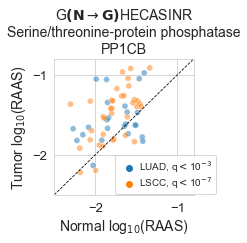

In [11]:
saap = 'GGHECASINR'

# get data for plot from tvn_dict
saap_df_list = []
for ds in tvn_datasets:
    ds_df = tvn_dict[ds]
    saap_df = ds_df.loc[ds_df['SAAP']==saap]
    saap_df_list.append(saap_df)
all_ds_saap_df = pd.concat(saap_df_list)
all_ds_saap_df = all_ds_saap_df.loc[:,['Dataset','Patient ID','Tumor RAAS','Normal RAAS']]
all_ds_saap_df.replace(np.inf, np.nan, inplace=True)
all_ds_saap_df.replace(-np.inf, np.nan, inplace=True)
all_ds_saap_df.dropna(inplace=True, how='any')

# plot scatterplot of tumor vs normal RAAS for datasets 
plot_ds_saap_df = all_ds_saap_df.loc[all_ds_saap_df['Dataset'].isin(['LUAD','LSCC'])]
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(2.5,2.5))
sns.scatterplot(data = plot_ds_saap_df, x='Normal RAAS', y='Tumor RAAS',hue='Dataset', s=35, alpha=0.5, hue_order=['LUAD','LSCC'])
plt.title('G'+r'$\bf(N$'+r'$\rightarrow$'+r'$\bfG)$'+saap[2:]+'\nSerine/threonine-protein phosphatase\nPP1CB', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.ylabel('Tumor log$_{10}$(RAAS)', fontsize=14)
plt.xlabel('Normal log$_{10}$(RAAS)', fontsize=14)
plt.xlim([-2.5, -0.8])
plt.ylim(plt.xlim())
plt.xticks([-2,-1]);
plt.yticks([-2,-1]);
plt.plot(plt.ylim(), plt.ylim(), '--k', linewidth=0.8)
handles, labels = ax.get_legend_handles_labels()

# pvalues used in legend are computed below 
plt.legend(handles = handles, labels = ['LUAD, q$<$10$^{-3}$', 'LSCC, q$<$10$^{-7}$'], 
           title='', loc='center', handletextpad=0, labelspacing=0, bbox_to_anchor=(0.8,0.15))
plt.savefig(outdir+saap+'_TRAAS_vs_NRAAS_allDS_PP1CB_LSCC_LUAD.pdf', bbox_inches='tight')

In [12]:
# showing pvalues between tumor and normal RAAS in patients for PSMA1 SAAP in each dataset
# used in plot annotation 

ps = []
for ds in tvn_datasets:
    print(ds)
    ds_df = all_ds_saap_df.loc[all_ds_saap_df['Dataset']==ds]
    print(sp.stats.ttest_rel(ds_df['Normal RAAS'].values, ds_df['Tumor RAAS'].values, alternative='less'))
    ps.append(sp.stats.ttest_rel(ds_df['Normal RAAS'].values, ds_df['Tumor RAAS'].values, alternative='less')[1])
adj_ps = multipletests(ps, method='fdr_bh')[1]
for i,ds in enumerate(tvn_datasets):
    print(ds, adj_ps[i])

CCRCC
Ttest_relResult(statistic=nan, pvalue=nan)
UCEC
Ttest_relResult(statistic=-1.0216879217980037, pvalue=0.16354248723086207)
LUAD
Ttest_relResult(statistic=-3.2494241263298558, pvalue=0.001703367529836577)
PDAC
Ttest_relResult(statistic=3.720223362801024, pvalue=0.9985371625972795)
LSCC
Ttest_relResult(statistic=-5.946705443205475, pvalue=4.537749831169248e-07)
CCRCC nan
UCEC nan
LUAD nan
PDAC nan
LSCC nan


/Users/shiri/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:327: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


### Figure 4b: AAS types up in tumor

/Users/shiri/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log2
/Users/shiri/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

/Users/shiri/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shiri/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/Users/shiri/anaconda3/lib/python3.7/sit

/Users/shiri/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log2
/Users/shiri/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log2
/Users/shiri/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log2
/Users/shiri/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4530: SettingWithCopyWarning: 
A value i

/Users/shiri/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shiri/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/Users/shiri/anaconda3/lib/python3.7/sit

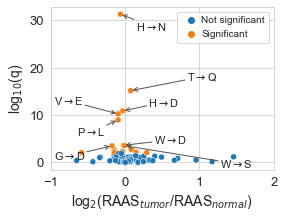

In [13]:
def get_aas_type(saap, bp):
    aas_idx = [i for i,x in enumerate(bp) if saap[i]!=x][0]
    enc = bp[aas_idx]
    inc = saap[aas_idx]
    aas = enc+' to '+inc
    return(aas)


aas_type_tvn_raas_df_list = []
for ds in patient_level_tvn_dict.keys():
    ds_df = patient_level_tvn_dict[ds]
    ds_df['AAS type'] = ds_df.apply(lambda x: get_aas_type(x['SAAP'], x['BP']), axis=1)
    aas_type_tvn_raas_df_list.append(ds_df.loc[:,['Tumor RAAS', 'Normal RAAS', 'AAS type']])

aas_type_tvn_raas = pd.concat(aas_type_tvn_raas_df_list)

set_aas = list(set(aas_type_tvn_raas['AAS type'].to_list()))
fc_rows = []
fc_cols = ['AAS type', 'Log2FC', 'pvalue', 'N']
for aas in set_aas:
    aas_df = aas_type_tvn_raas.loc[aas_type_tvn_raas['AAS type']==aas]
    aas_df.replace(np.inf, np.nan, inplace=True)
    aas_df.replace(-np.inf, np.nan, inplace=True)
    aas_df.dropna(how='any', inplace=True)
    aas_t = aas_df['Tumor RAAS'].values
    aas_n = aas_df['Normal RAAS'].values
    l2fc = np.mean([np.log2(aas_t[i]/aas_n[i]) for i in range(len(aas_t))])
    p = sp.stats.ttest_rel(aas_t, aas_n)[1]
    fc_rows.append([aas, l2fc, p, len(aas_t)])
    
fc_df = pd.DataFrame(fc_rows, columns=fc_cols)
fc_df['adj_p'] = multipletests(fc_df['pvalue'].values, method='fdr_bh')[1]


fc_df['-log q'] = [-np.log10(x) for x in fc_df['adj_p'].values]
fc_df.dropna(how='any', inplace=True)
fc_df['Significant'] = ['Significant' if row['-log q']>2 else 'Not significant' for i,row in fc_df.iterrows()]

fig,ax = plt.subplots(figsize=(4,3))
sns.scatterplot(data=fc_df, x='Log2FC', y='-log q', hue='Significant')
ax.tick_params('both', labelsize=13)
plt.ylabel('log$_{10}$(q)', fontsize=14)
plt.xlabel('log$_2$(RAAS$_{tumor}$/RAAS$_{normal}$)', fontsize=14)
plt.xlim([-1,2])
plt.legend(title='', handletextpad=0)


sig_df = fc_df.loc[fc_df['Significant']=='Significant']
texts = []
for i,row in sig_df.iterrows():
    x=row['Log2FC']
    y=row['-log q']
    s=row['AAS type'][0]+r'$\rightarrow$'+row['AAS type'][-1]
    if y>3:
        texts.append(ax.text(x,y,s,fontsize=11))
adjust_text(texts, expand_points=(2,2), expand_text=(2,2), ax=fig.axes[0],
            arrowprops=dict(arrowstyle='->', color='#555555', lw=1), force_text=0.3)

plt.savefig(outdir+'TvsN_global_AAStype_FC_volcano.pdf', bbox_inches='tight')

### Extended Data Figure 6b: RAAS vs. tumor stage

Requires clinical data provided as supplemental files in CPTAC publications - available in the google drive 

In [20]:
# read in clinical data 
ccrcc_clin_data = pd.read_excel(ccrcc_proj_dir+'Publication/CPTAC_ccRCC_metadata/S044_CPTAC_CCRCC_Discovery_Cohort_Clinical_Data_r2_Jan2019.xlsx', skiprows=2)
lscc_clin_data = pd.read_excel(lscc_proj_dir+'Publication/S063_S058_CPTAC_LSCC_Discovery_Cohort_Clinical_Data_r2_July2021.xlsx', sheet_name='Patient_Clinical_Attributes')
pdac_clin_data = pd.read_excel(pdac_proj_dir+'Publication/S061_CPTAC_PDA_Discovery_Cohort_Clinical_Data_r1_Feb2021.xlsx', sheet_name='Patient_Clinical_Attributes')
ucec_clin_data = pd.read_excel(ucec_proj_dir+'Publication/S053_S043_CPTAC_UCEC_Discovery_Cohort_Clinical_Data_r2_Feb2020.xlsx', sheet_name='Patient_Clinical_Attributes')
luad_clin_data = pd.read_excel(luad_proj_dir+'Publication/mmc1_metadata.xlsx', sheet_name='Annotions_S1A')
brca_clin_data = pd.read_excel(brca_proj_dir+'Publication/Krug_metaData.xlsx', sheet_name='A) Metadata')

# create lists in same order as dataset_list
# list of clinical data for each dataset
clin_data_list = [ccrcc_clin_data, ucec_clin_data, brca_clin_data, luad_clin_data, pdac_clin_data, lscc_clin_data]
# list of column name indicating sample ID in clinical data for each dataset
patient_col_list = ['Case_ID', 'case_id', 'Sample.ID', 'Participant', 'case_id', 'case_id']
# list of column name indicating tumor stage in clinical data for each dataset
tumor_stage_col_list = ['Tumor_Stage_Pathological', 'tumor_stage_pathological', 'Tumor.Stage', 'Stage', 'tumor_stage_pathological', 'tumor_stage_pathological']

stages = ['Stage I', 'Stage II','Stage III', 'Stage IV', 'unknown']

In [17]:
def reduce_stage(stage):
    """ function to get Stage I, II, or III from stage subsets
        Streamlines annotation of tumor stage across datasets
    """
    if (stage=='Stage IA') or (stage=='Stage IB') or (stage=='Stage IA3') or (stage=='1A') or (stage==1) or (stage=='1B'):
        stage = 'Stage I'
    elif (stage=='Stage IIA') or (stage=='Stage IIB') or (stage=='2A') or (stage=='2B'):
        stage = 'Stage II'
    elif (stage=='Stage IIIA') or (stage=='Stage IIIB') or (stage=='Stage IIIC') or (stage=='3A'):
        stage = 'Stage III'
    return(stage)


def get_tumor_stage(ds, patient):
    """ function to get clinical tumor stage for a patient sample in a dataset """
    clin_data = clin_data_list[datasets.index(ds)]
    case_col = patient_col_list[datasets.index(ds)]
    tumor_stage_col = tumor_stage_col_list[datasets.index(ds)]
    if ds!='LUAD':
        stage = clin_data.loc[clin_data[case_col]==patient, tumor_stage_col].values[0]
    else:
        stage = clin_data.loc[(clin_data[case_col]==patient) & (clin_data['Type']=='Tumor'), tumor_stage_col].values[0]
    stage = reduce_stage(stage)
    return(stage)

/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/shiri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/shiri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/shiri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/shiri/anaconda3/lib/python3.7/site-packages/numpy

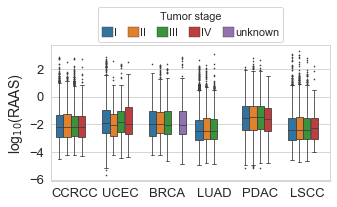

In [22]:
# plot boxplots of median RAAS per patient, stratified by patient tumor stage 

plot_df  = filt_reporter_quant_df.loc[filt_reporter_quant_df['Sample type']=='Tumor']
plot_df['Tumor stage'] = plot_df.apply(lambda x: get_tumor_stage(x['Dataset'], x['Sample name'].split('_')[0]), axis=1)

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(5,2.5))
sns.boxplot(data=plot_df, y='RAAS', x='Dataset', hue='Tumor stage', hue_order=stages, fliersize=0.75, linewidth=0.8)#, color='#AAAAAA')
plt.ylabel('log$_{10}$(RAAS)', fontsize=14)
plt.xlabel('')
ax.tick_params('both', labelsize=13)
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles = handles, labels=['I', 'II', 'III','IV','unknown'], ncol=5, bbox_to_anchor=(0.5,1.15), fontsize=11, loc='center', columnspacing=1, handletextpad=0.1, title='Tumor stage', title_fontsize=11)
plt.savefig(outdir+'RAAS_vs_TumorStage_SAAPupinT_boxplot_byDataset.pdf', bbox_inches='tight')

# Extended Data Figure 9a: Pfam domain enrichment

In [38]:
# read in Supplemental_Data_2.SAAP_proteins.xlsx
filt_saap_df = pd.read_excel(proj_dir+'Supplemental_Data_2.SAAP_proteins.xlsx', index_col=0)

# convert columns with Pfam domain information to lists 
filt_saap_df['Pfam domains'] = [x.split(';') if isinstance(x,str) else [] for x in filt_saap_df['Pfam domains'].values]
filt_saap_df['SAAP in Pfam domains'] = [x.split(';') if isinstance(x,str) else [] for x in filt_saap_df['SAAP in Pfam domains'].values]

In [102]:
# create a dataframe with p-values for significance of RAAS in Pfam domains
# pvalues are computed by comparing the RAAS for all peptides mapping to a given domain relative to random set of 5000 RAAS using KS test

ds_saap_df = filt_saap_df
ds_list = []
domain_list = []
raas_list = []
for i,row in ds_saap_df.iterrows():
    doms = row['Pfam domains']
    if ds =='Healthy':
        raas = row['Mean precursor RAAS']
    else:
        raas = row['Mean reporter RAAS']
    saap_in_doms = row['SAAP in Pfam domains']
    if isinstance(doms, str):
        keep_doms = []
        if saap_in_doms=='True' and doms not in keep_doms:
            keep_doms.append(doms)
        for dom in keep_doms:
            domain_list.append(doms)
            raas_list.append(raas)
            ds_list.append(row['Dataset'])
    elif isinstance(doms, list):
        keep_doms = []
        for d, dom in enumerate(doms):
            if saap_in_doms[d]=='True' and dom not in keep_doms:
                keep_doms.append(dom)
        for dom in keep_doms:
            domain_list.append(dom)
            raas_list.append(raas)
            ds_list.append(row['Dataset'])
    else:
        domain_list.append('Unidentified domain')
        raas_list.append(raas)
        ds_list.append(row['Dataset'])
ds_saap_df.dropna(subset=['Pfam domains'], axis=0, inplace=True)
set_pfam_domains = list(set(ds_saap_df['Pfam domains'].values))
set_pfam_domains.append('Unidentified domain')
pfam_raas_df = pd.DataFrame(zip(ds_list, domain_list, raas_list), columns=['Dataset','Domain', 'Mean RAAS'])
pfam_raas_df.to_excel(outdir+'Pfam_RAAS_df_allDS.xlsx')


# get random domain RAAS
random_domain_raas_assignments = {dom:{'Random RAAS':[]} for dom in set_pfam_domains}
raas_mean = np.mean([x for x in raas_list if ~np.isnan(x)])
raas_std = np.std([x for x in raas_list if ~np.isnan(x)])
ct=0
while ct<5000:
    for domain in set_pfam_domains:
        random_domain_raas_assignments[domain]['Random RAAS'].append(np.random.normal(raas_mean, raas_std, 1))
    ct+=1
domain_raas_dict = {domain:{'RAAS list':list(pfam_raas_df.loc[pfam_raas_df['Domain']==domain, 'Mean RAAS'].values)} for domain in set_pfam_domains}
if ds == 'Healthy':
    all_raas = [x for x in ds_saap_df['Mean precursor RAAS'] if ~np.isnan(x)]
else:
    all_raas = [x for x in ds_saap_df['Mean reporter RAAS'] if ~np.isnan(x)]

# compute significance of RAAS in each domain using KS test
domain_sig_rows = []
domain_sig_cols = ['Domain', 'N peptides', 'Median RAAS', 'Mean RAAS','p_KS']
for domain, domain_dict in domain_raas_dict.items():
    domain_raas_list = [x for x in domain_dict['RAAS list'] if ~np.isnan(x)]
    n_peps = len(domain_raas_list)
    if n_peps>0:
        domain_median_raas = np.median(domain_raas_list)
        domain_mean_raas = np.mean(domain_raas_list)
        domain_random_raas_list = random_domain_raas_assignments[domain]['Random RAAS']
        ks_p = sp.stats.ks_2samp(domain_raas_list, all_raas)[1]
        domain_sig_rows.append([domain, n_peps, domain_median_raas, domain_mean_raas, ks_p])
        domain_raas_dict[domain]['N peptides'] = n_peps
        domain_raas_dict[domain]['Median RAAS'] =  domain_median_raas
        domain_raas_dict[domain]['Mean RAAS'] = domain_mean_raas
        domain_raas_dict[domain]['p_KS'] = ks_p
domain_sig_df = pd.DataFrame(domain_sig_rows, columns=domain_sig_cols)

# adjust pvalues
ks_pvals = domain_sig_df['p_KS'].values
ks_pvals_adj = multipletests(ks_pvals, method='fdr_bh')[1]
domain_sig_df['p_KS_adj'] = ks_pvals_adj

domain_sig_df.to_excel(data_dir+'Pfam_domain_RAAS_significance_allDS.xlsx')

In [103]:
# read in file which has pvalues for each dataset
all_ds_dom_dicts = pickle.load(open(proj_dir+'pipeline_output/analysis_dependencies/All_DS_Pfam_dom_dict.p', 'rb'))

# add dataset specific pvalues to Pfam domain dataframe
domain_sig_df['CCRCC_p'] = np.nan
domain_sig_df['UCEC_p'] = np.nan
domain_sig_df['BRCA_p'] = np.nan
domain_sig_df['LUAD_p'] = np.nan
domain_sig_df['PDAC_p'] = np.nan
domain_sig_df['LSCC_p'] = np.nan
domain_sig_df['N sig'] = np.nan

for i,row in domain_sig_df.iterrows():
    dom = row['Domain']
    ps = []
    for ds in datasets[:-1]:
        dom_dict = all_ds_dom_dicts[ds]
        if dom in dom_dict:
            dom_dict = dom_dict[dom]
            p = dom_dict['p-value']
            ps.append(p)
            domain_sig_df.loc[i, ds+'_p'] = p
    n_sig = len([x for x in ps if x<0.05])
    domain_sig_df.loc[i, 'N sig'] = n_sig
domain_sig_df.to_excel(outdir+'Pfam_domain_RAAS_significance_allDS.xlsx')

In [105]:
ds = 'Healthy'
for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    ds_pfam_raas_df = pfam_raas_df.loc[pfam_raas_df['Dataset']==ds]

    # get random domain RAAS
    random_domain_raas_assignments = {dom:{'Random RAAS':[]} for dom in set_pfam_domains}
    raas_mean = np.mean([x for x in raas_list if ~np.isnan(x)])
    raas_std = np.std([x for x in raas_list if ~np.isnan(x)])
    ct=0
    while ct<5000:
        for domain in set_pfam_domains:
            random_domain_raas_assignments[domain]['Random RAAS'].append(np.random.normal(raas_mean, raas_std, 1))
        ct+=1
    domain_raas_dict = {domain:{'RAAS list':list(ds_pfam_raas_df.loc[ds_pfam_raas_df['Domain']==domain, 'Mean RAAS'].values)} for domain in set_pfam_domains}
    if ds == 'Healthy':
        all_raas = [x for x in ds_saap_df['Mean precursor RAAS'] if ~np.isnan(x)]
    else:
        all_raas = [x for x in ds_saap_df['Mean reporter RAAS'] if ~np.isnan(x)]


    # compute significance of RAAS in each domain using KS test
    domain_sig_rows = []
    domain_sig_cols = ['Domain', 'N peptides', 'Median RAAS', 'Mean RAAS','p_KS']
    for domain, domain_dict in domain_raas_dict.items():
        domain_raas_list = [x for x in domain_dict['RAAS list'] if ~np.isnan(x)]
        n_peps = len(domain_raas_list)
        if n_peps>0:
            domain_median_raas = np.median(domain_raas_list)
            domain_mean_raas = np.mean(domain_raas_list)
            domain_random_raas_list = random_domain_raas_assignments[domain]['Random RAAS']
            ks_p = sp.stats.ks_2samp(domain_raas_list, all_raas)[1]
            domain_sig_rows.append([domain, n_peps, domain_median_raas, domain_mean_raas, ks_p])
            domain_raas_dict[domain]['N peptides'] = n_peps
            domain_raas_dict[domain]['Median RAAS'] =  domain_median_raas
            domain_raas_dict[domain]['Mean RAAS'] = domain_mean_raas
            domain_raas_dict[domain]['p_KS'] = ks_p
    ds_domain_sig_df = pd.DataFrame(domain_sig_rows, columns=domain_sig_cols)

    # adjust pvalues
    ks_pvals = ds_domain_sig_df['p_KS'].values
    ks_pvals_adj = multipletests(ks_pvals, method='fdr_bh')[1]
    ds_domain_sig_df['p_KS_adj'] = ks_pvals_adj

    ds_domain_sig_df.to_excel(data_dir+ds+'_Pfam_domain_RAAS_significance.xlsx')

Healthy


In [107]:
# extract domains to plot - those that have significant pvalues in at least 4 datasets 
doms2plot = domain_sig_df.loc[domain_sig_df['N sig']>=4, 'Domain'].to_list()
raas = domain_sig_df.loc[domain_sig_df['N sig']>=4, 'Median RAAS'].to_list()
sorted_idx = np.argsort(raas)
sorted_domains = [doms2plot[i] for i in sorted_idx]

x_labels = datasets
y_labels = sorted_domains

# get data for plot - color data = RAAS, size data = N peptides with domain 
color_data = pd.DataFrame(index=y_labels, columns=datasets)
size_data = pd.DataFrame(index=y_labels, columns=datasets)
for i in x_labels:
    data_dir = data_dir_list[datasets.index(i)]
    domain_ds_df = pd.read_excel(data_dir+i+'_Pfam_domain_RAAS_significance.xlsx')
    for j in y_labels:
        dom_ds_row = domain_ds_df.loc[(domain_ds_df['Domain']==j)]
        if len(dom_ds_row)>0:
            color_data.loc[j,i] = dom_ds_row['Median RAAS'].values[0]
            n =  dom_ds_row['N peptides'].values[0]
            size_data.loc[j,i] =n

color_data = color_data.astype(float)
size_data = size_data.astype(float)

color_data.to_excel(outdir+'Pfam_Domains_RAAS_SigIn4.xlsx')
size_data.to_excel(outdir+'Pfam_Domains_Npeps_SigIn4.xlsx')

In [110]:
# combined repetitive domains manually 
color_data = pd.read_excel(dependencies_dir+'Pfam_Domains_RAAS_SigIn4.xlsx', index_col=0)
size_data = pd.read_excel(dependencies_dir+'Pfam_Domains_Npeps_SigIn4.xlsx', index_col=0)


# pathway order - high mean raas on top 
doms2plot = list(set(color_data.index))
medians = [np.nanmean(row.values) for i, row in color_data.iterrows()]
sorted_idx = np.argsort(medians)
sorted_domains = [color_data.index.to_list()[i] for i in sorted_idx]
color_data = color_data.loc[sorted_domains]
size_data = size_data.loc[sorted_domains]

# adjust sizes for visualization purposes 
import copy
size_data2plot = copy.deepcopy(size_data)
for i,row in size_data2plot.iterrows():
    for col in size_data2plot.columns:
        if size_data.loc[i,col]<5:
            size_data2plot.loc[i,col] = 0.3
        elif size_data.loc[i,col]<50:
            size_data2plot.loc[i,col] = 0.4
        else:
            size_data2plot.loc[i,col] = 0.5

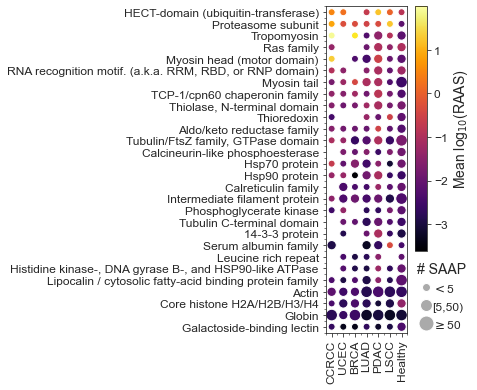

In [111]:
# plot dotplot of domains with significantly high RAAS 

M=len(datasets)
N=len(sorted_domains)
x, y = np.meshgrid(np.arange(M), np.arange(N))

x_labels = datasets
y_labels = sorted_domains

sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(13,6))
s = size_data2plot.values
c = color_data.values
R = s

circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap=custom_cmap)
ax.add_collection(col)
ax.set_aspect('equal')
ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=x_labels, yticklabels=y_labels)
ax.tick_params('both', labelsize=12)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.tick_params('x', rotation=90)
cb = fig.colorbar(col, shrink=0.75, anchor=(-0.3,1))
cb.ax.tick_params(labelsize=12)
cb.ax.set_ylabel('Mean log$_{10}$(RAAS)', fontsize=14)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='$<$5',markerfacecolor='#AAAAAA', markersize=8),
                  Line2D([0], [0], marker='o', color='w', label='[5,50)',markerfacecolor='#AAAAAA', markersize=12),
                  Line2D([0], [0], marker='o', color='w', label='$\geq$50',markerfacecolor='#AAAAAA', markersize=15)]

plt.legend(handles=legend_elements, handletextpad=0, title='# SAAP', bbox_to_anchor=(1.85,.25), frameon=False, fontsize=12, title_fontsize=14)
plt.savefig(outdir+'pfamdomains_sigin4_dotplot.pdf', bbox_inches='tight')